In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pyarrow.parquet as pq

In [2]:
!pip install kaggle

  Using cached kaggle-1.6.17-py3-none-any.whl
  Using cached python_slugify-8.0.4-py2.py3-none-any.whl.metadata (8.5 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl.metadata (2.4 kB)
Using cached python_slugify-8.0.4-py2.py3-none-any.whl (10 kB)
Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [5]:
BASE_DIR = 'data/asl-signs/'
train = pd.read_csv(f'{BASE_DIR}/train.csv')
xyz=pd.read_parquet(f'{BASE_DIR}/train_landmark_files/16069/695046.parquet') #note you will need the wlasl data set for this step. 

In [4]:
xyz.head() #checking data

,frame,row_id,type,landmark_index,x,y,z
0,105,105-face-0,face,0,0.459484,0.450040,-0.048297
1,105,105-face-1,face,1,0.451732,0.401943,-0.066326
2,105,105-face-2,face,2,0.452219,0.418714,-0.042678
3,105,105-face-3,face,3,0.438481,0.372725,-0.040756
4,105,105-face-4,face,4,0.450793,0.390858,-0.067166


In [5]:
xyz.columns

Index(['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z'], dtype='object')

In [6]:
xyz.shape

(21720, 7)

In [7]:
train.query('sequence_id == 695046')

,path,participant_id,sequence_id,sign
87142,train_landmark_files/16069/695046.parquet,16069,695046,mad


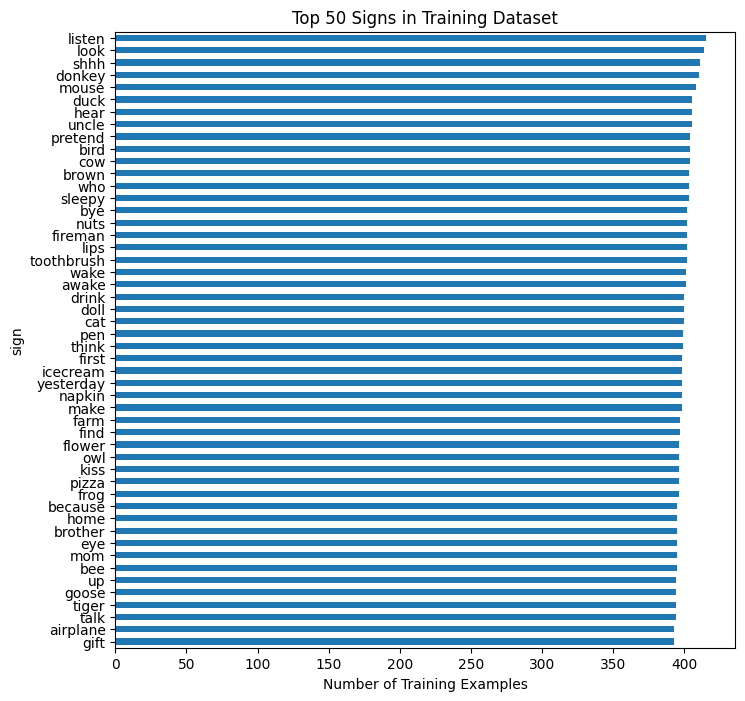

In [8]:
fig, ax = plt.subplots(figsize=(8, 8))
train["sign"].value_counts().head(50).sort_values(ascending=True).plot( #this is to understand the data we're working with by ranking the top 50 signs in the training dataset
    kind="barh", ax=ax, title="Top 50 Signs in Training Dataset"
)
ax.set_xlabel("Number of Training Examples")
plt.show()

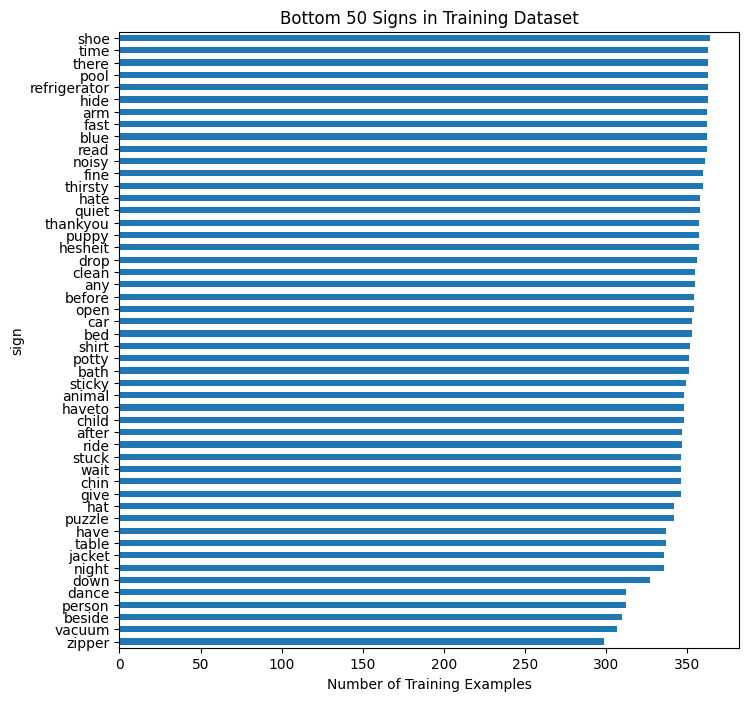

In [9]:
fig, ax = plt.subplots(figsize=(8, 8))
train["sign"].value_counts().tail(50).sort_values(ascending=True).plot(
    kind="barh", ax=ax, title="Bottom 50 Signs in Training Dataset" #same as before but the bottom 50 signs
)
ax.set_xlabel("Number of Training Examples")
plt.show()

In [10]:
example_fn = train.query('sign == "listen"')["path"].values[0]

example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")
example_landmark.head()

,frame,row_id,type,landmark_index,x,y,z
0,35,35-face-0,face,0,0.556969,0.431919,-0.039614
1,35,35-face-1,face,1,0.548688,0.394788,-0.077306
2,35,35-face-2,face,2,0.548806,0.405519,-0.040327
3,35,35-face-3,face,3,0.531849,0.356302,-0.058683
4,35,35-face-4,face,4,0.547539,0.382894,-0.082544


In [11]:
unique_frames = example_landmark["frame"].nunique()
unique_types = example_landmark["type"].nunique()
types_in_video = example_landmark["type"].unique()
print(
    f"The file has {unique_frames} unique frames and {unique_types} unique types: {types_in_video}"
)

The file has 6 unique frames and 4 unique types: ['face' 'left_hand' 'pose' 'right_hand']


In [12]:
N_PARQUETS_TO_READ = 100_000  
#skip this step cause its mad heavy
combined_meta = {}
for i, d in tqdm(train.iterrows(), total=len(train)):
    file_path = d["path"]
    example_landmark = pd.read_parquet(f"{BASE_DIR}/{file_path}")
    # Get the number of landmarks with x,y,z data per type
    meta = (
        example_landmark.dropna(subset=["x", "y", "z"])["type"].value_counts().to_dict()
    )
    meta["frames"] = example_landmark["frame"].nunique()
    xyz_meta = (
        example_landmark.agg(
            {
                "x": ["min", "max", "mean"],
                "y": ["min", "max", "mean"],
                "z": ["min", "max", "mean"],
            }
        )
        .unstack()
        .to_dict()
    )

    for key in xyz_meta.keys():
        new_key = key[0] + "_" + key[1]
        meta[new_key] = xyz_meta[key]
    combined_meta[file_path] = meta
    if i >= N_PARQUETS_TO_READ:
        break


  0%|          | 0/94477 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [21]:
train_with_meta = train.merge( #skip this too
    pd.DataFrame(combined_meta).T.reset_index().rename(columns={"index": "path"}),
    how="left",
)
train_with_meta.to_parquet("train_with_meta.parquet")

NameError: name 'combined_meta' is not defined

In [13]:
train_with_meta=pd.read_parquet("train_with_meta.parquet") #this is a test. it will be included

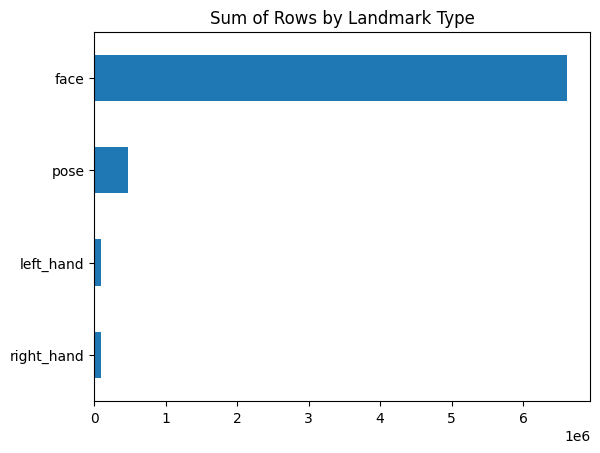

In [14]:
train_with_meta[["face", "pose", "left_hand", "right_hand"]].sum().sort_values().plot(
    kind="barh", title="Sum of Rows by Landmark Type"
)
plt.show()

<Axes: title={'center': 'Rate of Frame/Keypoints with Data'}>

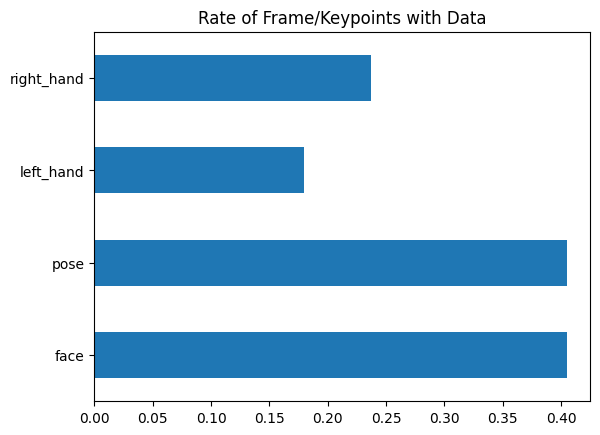

In [15]:
# checking to see if the number of landmarks for this type is zero
(
    train_with_meta.query("index < 1000").fillna(0)[
        ["face", "pose", "left_hand", "right_hand"]
    ]
    > 0
).mean().plot(kind="barh", title="Rate of Frame/Keypoints with Data")

In [16]:
example_fn = train_with_meta.dropna().query('sign == "shhh"')["path"].values[0]
example_landmark = pd.read_parquet(f"{BASE_DIR}/{example_fn}")

In [17]:
example_landmark.query("frame == 25")["type"].value_counts()  # Middle of the video

type
face          468
pose           33
left_hand      21
right_hand     21
Name: count, dtype: int64

In [19]:
example_landmark["no_xyz"] = example_landmark["x"].isna()

In [20]:
example_landmark #debug

,frame,row_id,type,landmark_index,x,y,z,no_xyz
0,14,14-face-0,face,0,0.432380,0.375417,-0.044000,False
1,14,14-face-1,face,1,0.437980,0.349091,-0.070176,False
2,14,14-face-2,face,2,0.429624,0.360922,-0.040331,False
3,14,14-face-3,face,3,0.430260,0.315678,-0.049688,False
4,14,14-face-4,face,4,0.441155,0.338613,-0.073218,False
...,...,...,...,...,...,...,...,...
12484,36,36-right_hand-16,right_hand,16,NaN,NaN,NaN,True
12485,36,36-right_hand-17,right_hand,17,NaN,NaN,NaN,True
12486,36,36-right_hand-18,right_hand,18,NaN,NaN,NaN,True
12487,36,36-right_hand-19,right_hand,19,NaN,NaN,NaN,True


<Axes: title={'center': 'missing xyz per frame'}, xlabel='frame'>

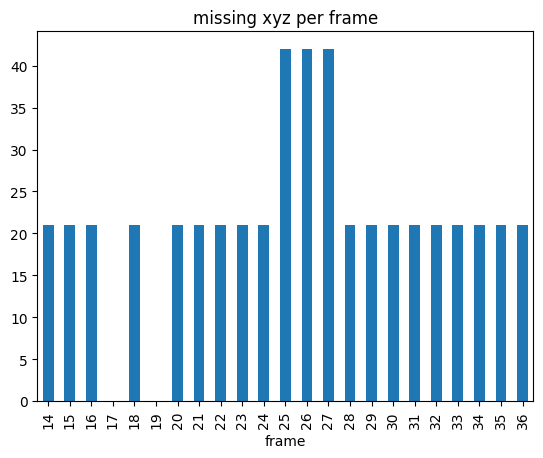

In [21]:
example_landmark.groupby("frame")["no_xyz"].sum().plot(
    title="missing xyz per frame", kind="bar"
)

In [23]:
import plotly.express as px #this is worth checking out. it's a 3d plot of the landmarks. could be used for demo

example_frame = example_landmark.query("frame == 25")
px.scatter_3d(example_frame, x="x", y="y", z="z", color="type")

In [24]:
example_landmark["y_"] = example_landmark["y"] * -1
example_frame = example_landmark.query("frame == 25 and type== 'face'")
px.scatter(example_frame, x="x", y="y_", color="type")

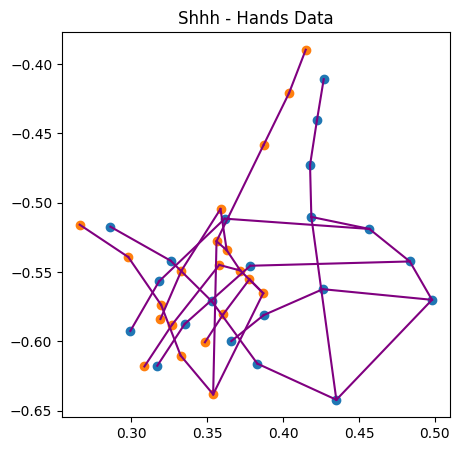

In [25]:
import mediapipe as mp

mp_hands = mp.solutions.hands


example_landmark["y_"] = example_landmark["y"] * -1

fig, ax = plt.subplots(figsize=(5, 5))

for hand in ["left_hand", "right_hand"]:
    example_hand = example_landmark.query("frame == 17 and type == @hand")

    ax.scatter(example_hand["x"], example_hand["y_"])

    for connection in mp_hands.HAND_CONNECTIONS:
        point_a = connection[0]
        point_b = connection[1]
        x1, y1 = example_hand.query("landmark_index == @point_a")[["x", "y_"]].values[0]
        x2, y2 = example_hand.query("landmark_index == @point_b")[["x", "y_"]].values[0]
        plt.plot([x1, x2], [y1, y2], color="purple")
ax.set_title("Shhh - Hands Data")
plt.show()

In [26]:
import cv2
import mediapipe as mp
import numpy as np
import os 
mp_drawing = mp.solutions.drawing_utils
mp_drawing_styles = mp.solutions.drawing_styles
mp_face_mesh = mp.solutions.face_mesh
mp_pose = mp.solutions.pose
mp_hands = mp.solutions.hands


# For static images:
IMAGE_FILES = [
    "asl_shh_test.jpg", #include more images to test the mediapipe annotations
]
BG_COLOR = (192, 192, 192)  # gray


landmarks_data = {}


output_dir = "tmp"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


with mp_face_mesh.FaceMesh(static_image_mode=True, refine_landmarks=True) as face_mesh, \
     mp_pose.Pose(static_image_mode=True) as pose, \
     mp_hands.Hands(static_image_mode=True) as hands:
    
    for idx, file in enumerate(IMAGE_FILES):
        image = cv2.imread(file)
        if image is None:
            print(f"Error loading image {file}")
            continue
        image_height, image_width, _ = image.shape
        # Convert the BGR image to RGB before processing.
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        
        # Ensure the image is writable
        image_rgb.flags.writeable = False
        
        try:
            # Process the image and draw landmarks
            face_results = face_mesh.process(image_rgb)
            pose_results = pose.process(image_rgb)
            hands_results = hands.process(image_rgb)
        except Exception as e:
            print(f"Error processing image {file}: {e}")
            continue
        
        image_rgb.flags.writeable = True

        annotated_image = image.copy()
        landmarks_data[file] = {
            'face_landmarks': [],
            'pose_landmarks': [],
            'hand_landmarks': []
        }

        # Draw face landmarks on the image and store them.
        if face_results and face_results.multi_face_landmarks:
            for face_landmarks in face_results.multi_face_landmarks:
                mp_drawing.draw_landmarks(
                    annotated_image,
                    face_landmarks,
                    mp_face_mesh.FACEMESH_TESSELATION,
                    landmark_drawing_spec=None,
                    connection_drawing_spec=mp_drawing_styles.get_default_face_mesh_tesselation_style(),
                )
                landmarks_data[file]['face_landmarks'].append([
                    (lm.x * image_width, lm.y * image_height, lm.z * image_width)
                    for lm in face_landmarks.landmark
                ])
        
        # Draw pose landmarks on the image and store them.
        if pose_results and pose_results.pose_landmarks:
            mp_drawing.draw_landmarks(
                annotated_image,
                pose_results.pose_landmarks,
                mp_pose.POSE_CONNECTIONS,
                landmark_drawing_spec=mp_drawing_styles.get_default_pose_landmarks_style(),
            )
            landmarks_data[file]['pose_landmarks'] = [
                (lm.x * image_width, lm.y * image_height, lm.z * image_width)
                for lm in pose_results.pose_landmarks.landmark
            ]
        
        # Draw hand landmarks on the image and store them.
        if hands_results and hands_results.multi_hand_landmarks:
            for hand_landmarks in hands_results.multi_hand_landmarks:
                mp_drawing.draw_landmarks(
                    annotated_image,
                    hand_landmarks,
                    mp_hands.HAND_CONNECTIONS,
                    landmark_drawing_spec=mp_drawing_styles.get_default_hand_landmarks_style(),
                )
                landmarks_data[file]['hand_landmarks'].append([
                    (lm.x * image_width, lm.y * image_height, lm.z * image_width)
                    for lm in hand_landmarks.landmark
                ])
        
        cv2.imwrite(os.path.join(output_dir, "annotated_image" + str(idx) + ".png"), annotated_image)

# Print the stored landmarks data
cv2.imwrite("tmp/annotated_image" + str(idx) + ".png", annotated_image)


c:\Users\kabir\.vscode\Code Files\ctp-ds-project\.venv\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning:

SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.



True

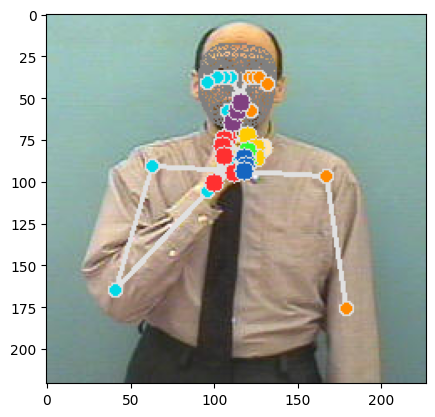

' #once you add more images, you can uncomment the below images one by one\nplt.imshow(plt.imread("tmp/annotated_image" + str(1) + ".png"))\nplt.show()\nplt.imshow(plt.imread("tmp/annotated_image" + str(2) + ".png"))\nplt.show()\n'

In [27]:
plt.imshow(plt.imread("tmp/annotated_image" + str(0) + ".png"))
plt.show()
''' #once you add more images, you can uncomment the below images one by one
plt.imshow(plt.imread("tmp/annotated_image" + str(1) + ".png"))
plt.show()
plt.imshow(plt.imread("tmp/annotated_image" + str(2) + ".png"))
plt.show()
'''

In [6]:
def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

In [11]:
import tensorflow as tf #this is the model that will be used to predict the sign language

def run_model(model_path, frames):
    # Initialize the TensorFlow Lite interpreter
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()

    # Get the list of available signatures
    found_signatures = list(interpreter.get_signature_list().keys())
    REQUIRED_SIGNATURE = "serving_default"

    # Check if the required signature is available
    if REQUIRED_SIGNATURE not in found_signatures:
        raise Exception('Required input signature not found.')

    # Get the prediction function from the interpreter
    prediction_fn = interpreter.get_signature_runner(REQUIRED_SIGNATURE)

    # Run the prediction function with the input frames
    output = prediction_fn(inputs=frames)
    sign = np.argmax(output["outputs"])

    return sign


In [7]:
train['sign_ord'] = train['sign'].astype('category').cat.codes
SIGN2ORD = train[['sign', 'sign_ord']].set_index('sign').squeeze().to_dict()
ORD2SIGN = train[['sign_ord', 'sign']].set_index('sign_ord').squeeze().to_dict()

In [8]:
import pandas as pd
import numpy as np

ROWS_PER_FRAME = 543  # Number of rows per frame, adjust as needed

def load_relevant_data_subset(pq_path):
    data_columns = ['x', 'y', 'z']
    data = pd.read_parquet(pq_path, columns=data_columns)
    print(data.columns)
    n_frames = int(len(data) / ROWS_PER_FRAME)
    data = data.values.reshape(n_frames, ROWS_PER_FRAME, len(data_columns))
    return data.astype(np.float32)

# Example usage
pq_path = 'data/asl-signs/train_landmark_files/16069/695046.parquet' #this is a test parquet. 
frames = load_relevant_data_subset(pq_path)
print(frames.shape)  # Should print (n_frames, ROWS_PER_FRAME, 3)

Index(['x', 'y', 'z'], dtype='object')
(40, 543, 3)


In [12]:
model_path = "model.tflite" #should return 'mad'
sign = ORD2SIGN[run_model(model_path, frames)]
print(f"Predicted sign: {sign}") 

Predicted sign: mad


In [14]:
sign_values = train['sign'].unique().tolist()
print(sign_values)

['blow', 'wait', 'cloud', 'bird', 'owie', 'duck', 'minemy', 'lips', 'flower', 'time', 'vacuum', 'apple', 'puzzle', 'mitten', 'there', 'dry', 'shirt', 'owl', 'yellow', 'not', 'zipper', 'clean', 'closet', 'quiet', 'have', 'brother', 'clown', 'cheek', 'cute', 'store', 'shoe', 'wet', 'see', 'empty', 'fall', 'balloon', 'frenchfries', 'finger', 'same', 'cry', 'hungry', 'orange', 'milk', 'go', 'drawer', 'TV', 'another', 'giraffe', 'wake', 'bee', 'bad', 'can', 'say', 'callonphone', 'finish', 'old', 'backyard', 'sick', 'look', 'that', 'black', 'yourself', 'open', 'alligator', 'moon', 'find', 'pizza', 'shhh', 'fast', 'jacket', 'scissors', 'now', 'man', 'sticky', 'jump', 'sleep', 'sun', 'first', 'grass', 'uncle', 'fish', 'cowboy', 'snow', 'dryer', 'green', 'bug', 'nap', 'feet', 'yucky', 'morning', 'sad', 'face', 'penny', 'gift', 'night', 'hair', 'who', 'think', 'brown', 'mad', 'bed', 'drink', 'stay', 'flag', 'tooth', 'awake', 'thankyou', 'hot', 'like', 'where', 'hesheit', 'potty', 'down', 'stuck'

In [15]:
#this is the final step. run this cell ONLY AFTER running capture_sign.py
pq_path = 'landmarks.parquet'
frames = load_relevant_data_subset(pq_path)
print(frames.shape)
sign = ORD2SIGN[run_model(model_path, frames)]
print(f"Predicted sign: {sign}")

Index(['x', 'y', 'z'], dtype='object')
(24, 543, 3)
Predicted sign: hello
